In [1]:
import numpy as np
import pandas as pd
from category_encoders import LeaveOneOutEncoder
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_feat = pd.read_csv('train_features.csv')
train_salary = pd.read_csv('train_salaries.csv')
test_feat = pd.read_csv('test_features.csv')

In [4]:
train_feat.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [5]:
train_salary.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [7]:
train_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [8]:
train_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   jobId   1000000 non-null  object
 1   salary  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [3]:
data = pd.merge(train_feat, train_salary, on = 'jobId', how = 'left')
data.to_csv('training.csv')
data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [10]:
print('There are {} duplicated jobIds'.format(len(data['jobId'])-len(data['jobId'].drop_duplicates())))

There are 0 duplicated jobIds


In [11]:
data.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [12]:
data.describe(include = ['O'])

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362685297383,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


In [13]:
data.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [14]:
cols = ['jobType','degree','major','industry']
for col in cols:
    print(col)
    print(data[col].unique())
    print()

jobType
['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']

degree
['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE']

major
['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING']

industry
['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE']



In [15]:
data[data['salary'] == 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [16]:
quartiles = data.salary.describe()
iqr = quartiles['75%'] - quartiles['25%']
upper = quartiles['75%'] + 1.5*iqr
lower = quartiles['25%'] - 1.5*iqr
print('The salary lower bound is {} and the upper bound is {}'.format(lower,upper))

The salary lower bound is 8.5 and the upper bound is 220.5


In [17]:
data.loc[data.salary > upper, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [18]:
data.loc[data.salary < lower, 'jobType'].value_counts()

JUNIOR            2
VICE_PRESIDENT    1
CTO               1
MANAGER           1
Name: jobType, dtype: int64

In [19]:
data[(data['salary'] >= upper) & (data['jobType'] == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


### Categorical Feature Analysis

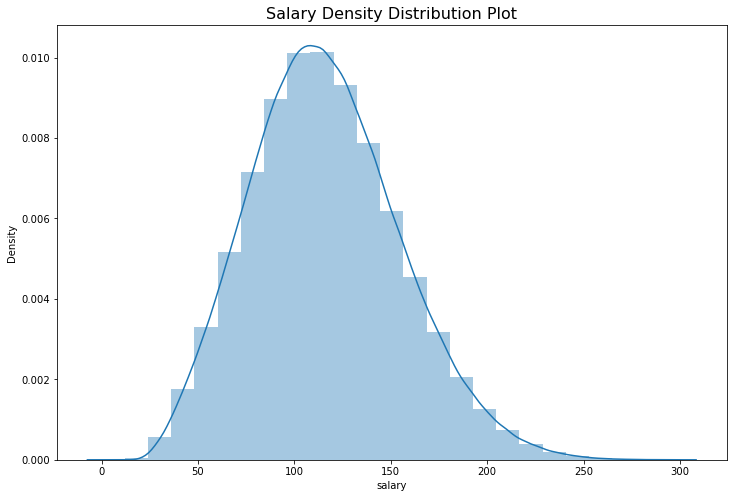

In [4]:
plt.figure(figsize=(12,8))
sns.distplot(data.salary, bins=25)
plt.title('Salary Density Distribution Plot', fontsize = 16);

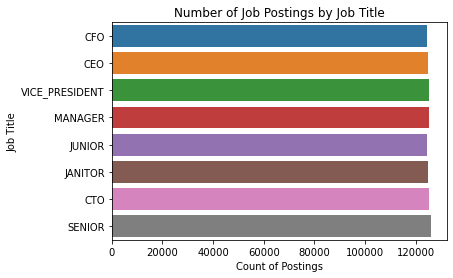

In [21]:
sns.countplot(y = 'jobType', data = data)
plt.ylabel('Job Title')
plt.xlabel('Count of Postings')
plt.title('Number of Job Postings by Job Title');

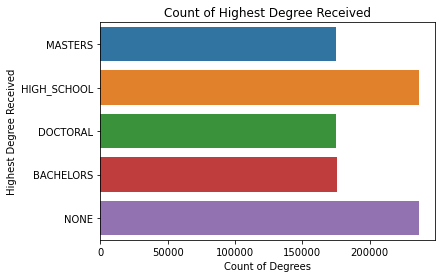

In [22]:
sns.countplot(y = 'degree', data = data)
plt.xlabel('Count of Degrees')
plt.ylabel('Highest Degree Received')
plt.title('Count of Highest Degree Received');

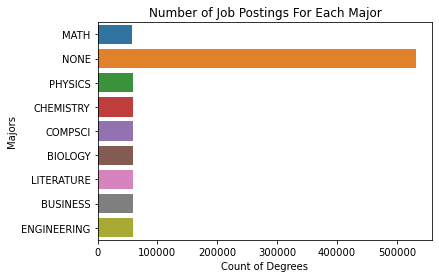

In [23]:
sns.countplot(y = 'major', data = data)
plt.xlabel('Count of Degrees')
plt.ylabel('Majors')
plt.title('Number of Job Postings For Each Major');

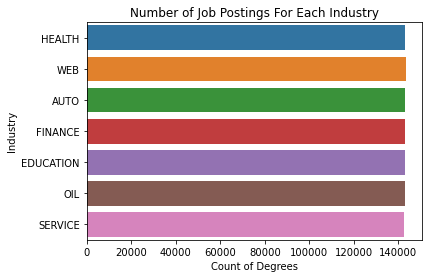

In [24]:
sns.countplot(y = 'industry', data = data)
plt.xlabel('Count of Degrees')
plt.ylabel('Industry')
plt.title('Number of Job Postings For Each Industry');

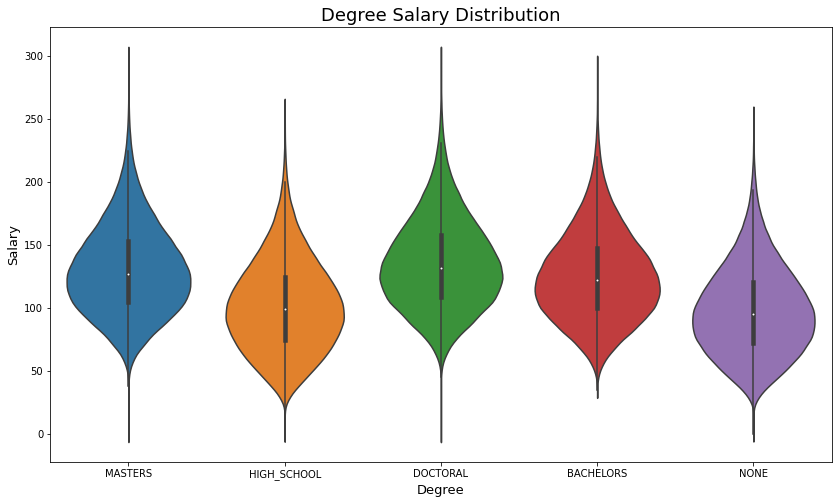

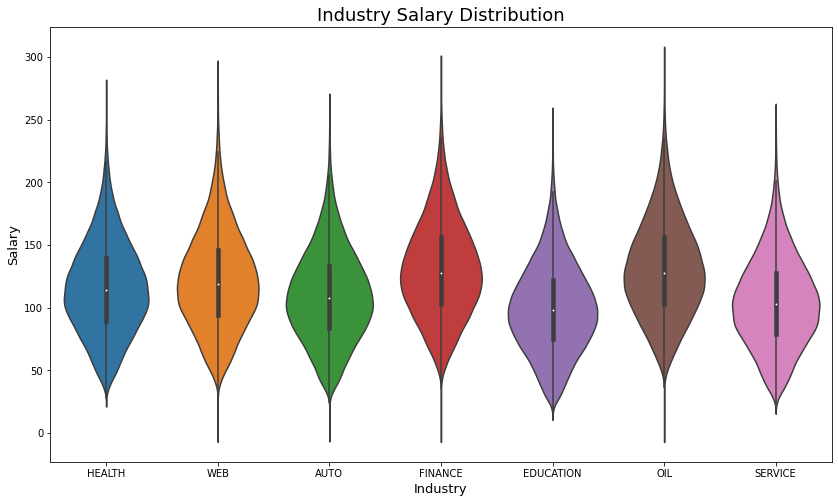

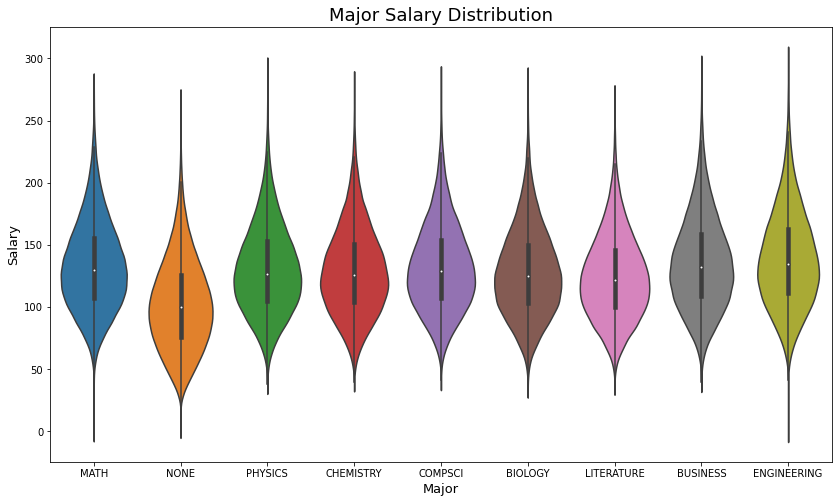

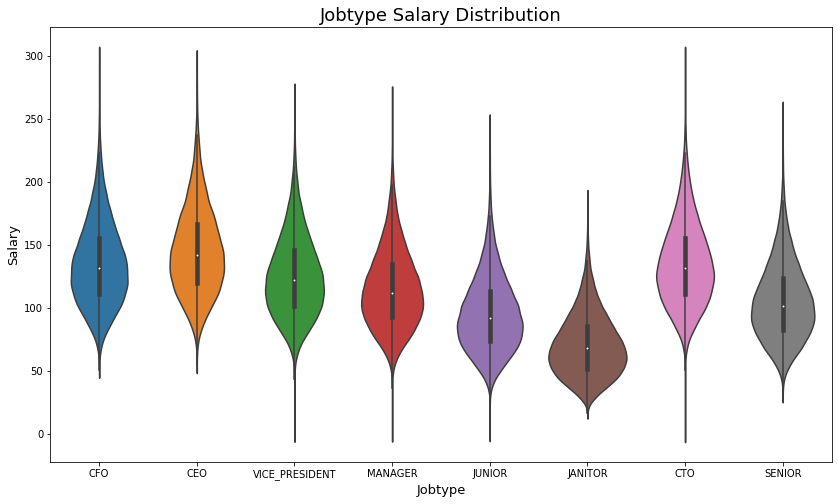

In [88]:
cols = ['degree','industry','major','jobType']
for col in cols:
    plt.figure(figsize=(14,8))
    sns.violinplot(x=data[col], y="salary",data=data)
    plt.title(F"{col.capitalize()} Salary Distribution", fontsize = 18)
    plt.xlabel(F"{col.capitalize()}", fontsize = 13)
    plt.ylabel('Salary',fontsize = 13);

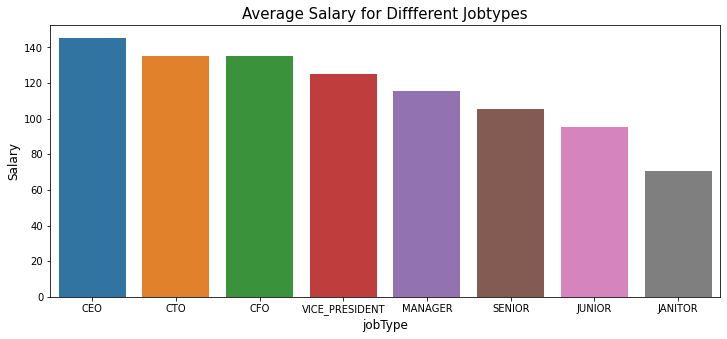

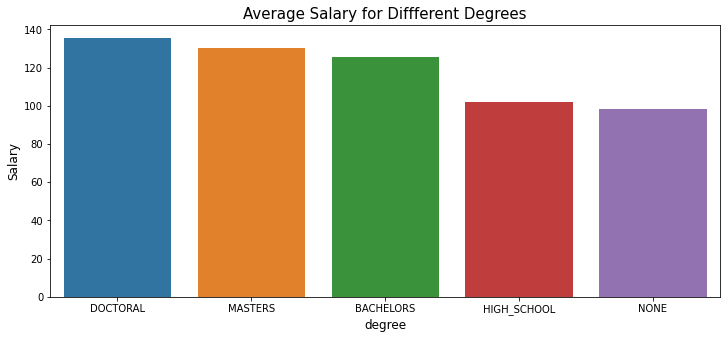

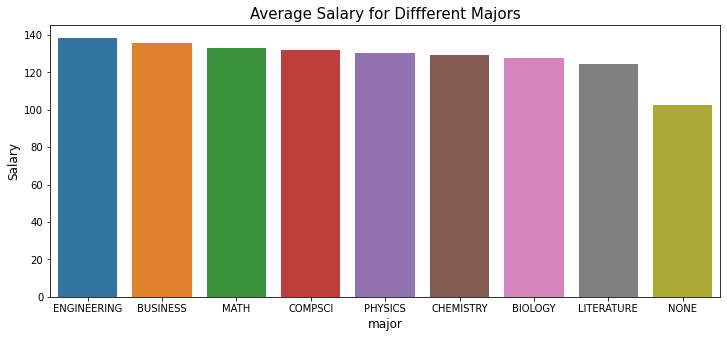

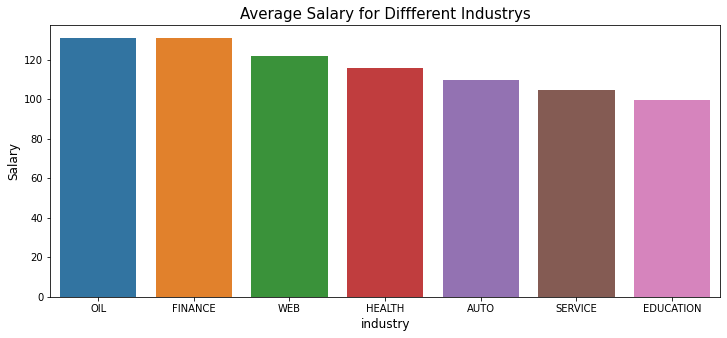

In [90]:
cols = ['jobType','degree','major','industry']
for col in cols:
    plt.figure(figsize=(12,5))
    df = pd.pivot_table(data, index = col, values = 'salary', aggfunc = 'mean').sort_values('salary', ascending=False)
    ax = sns.barplot(x=df.index, y="salary", data=df)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Salary', fontsize=12)
    plt.tick_params(labelsize = 10)
    plt.title(F"Average Salary for Diffferent {col.capitalize()}s", fontsize = 15)
    plt.show()

### Numerical Feature Analysis

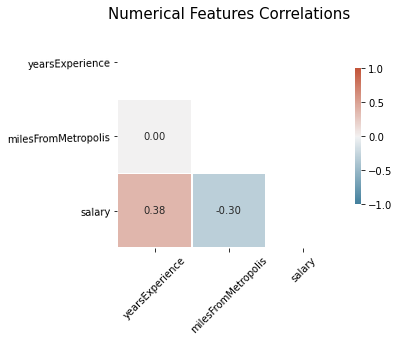

In [73]:
numerical = data[['yearsExperience','milesFromMetropolis','salary']]
num_corr = numerical.corr()

mask = np.triu(np.ones_like(num_corr, dtype=bool))
g, ax = plt.subplots(figsize=(5,5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(num_corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, 
            center=0, square=True,
            annot = True, annot_kws={"size": 10}, fmt=".2f", 
            linewidths=.5, cbar_kws={"shrink": .5})

ax.tick_params(axis = 'y',labelsize=10, rotation = 1)
ax.tick_params(axis = 'x',labelsize=10, rotation = 45)
plt.title('Numerical Features Correlations', fontsize = 15)
plt.savefig('NumeicalCorrelations.png', bbox_inches='tight');

In [5]:
target = train_salary['salary']
enc = LeaveOneOutEncoder()
corr_df = enc.fit_transform(train_feat,target)

In [6]:
looe_enc = pd.concat([corr_df, target], axis = 1)

In [7]:
corr = looe_enc.corr()

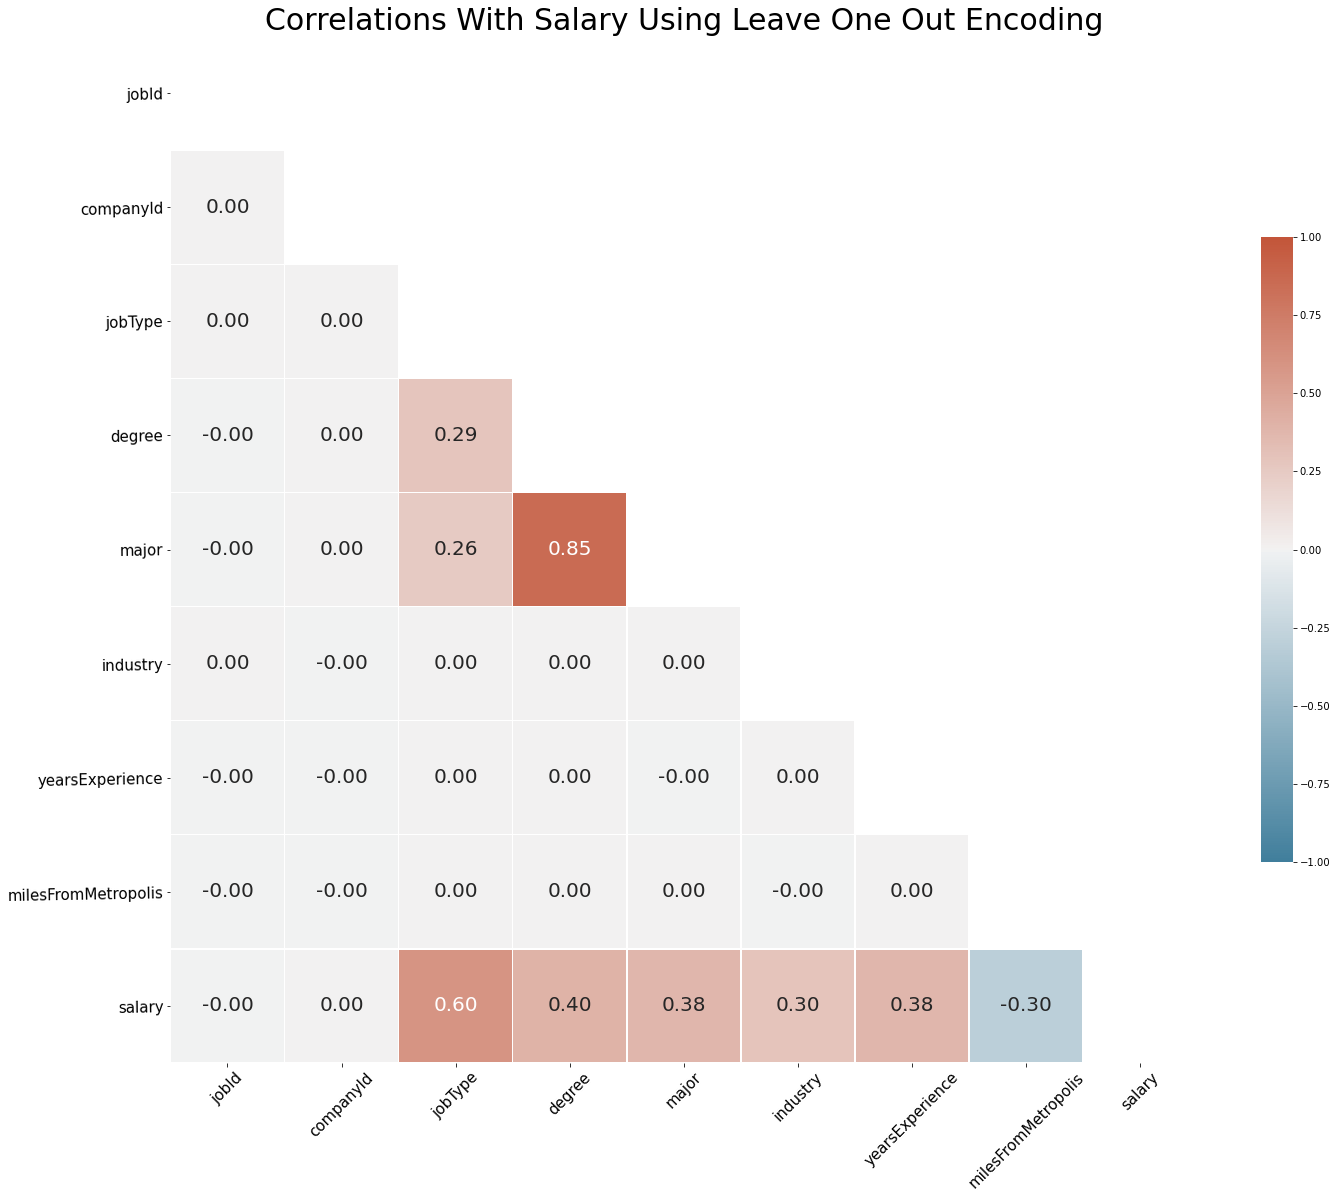

In [8]:
mask = np.triu(np.ones_like(corr, dtype=bool))
g, ax = plt.subplots(figsize=(23,23))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, 
            center=0, square=True,
            annot = True, annot_kws={"size": 20},fmt=".2f", 
            linewidths=.5, cbar_kws={"shrink": .5})
            
ax.tick_params(axis = 'y',labelsize=15, rotation = 1)
ax.tick_params(axis = 'x',labelsize=15, rotation = 45)
plt.title('Correlations With Salary Using Leave One Out Encoding', fontsize = 30)
plt.savefig('LeaveOneOutCorrelations.png', bbox_inches='tight');